In [285]:
import numpy as np
import matplotlib.pyplot as plt
from CAMB import camb
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [23]:
wmap = np.loadtxt('Intensity.txt')

In [263]:
#Copied the spectrum function written by Prof. Sievers
def get_spectrum(pars,lmax=2000,fixed_Tau=None):
    if fixed_Tau is None:
        H0=pars[0]
        ombh2=pars[1]
        omch2=pars[2]
        tau=pars[3]
        As=pars[4]
        ns=pars[5]
    else: 
        H0=pars[0]
        ombh2=pars[1]
        omch2=pars[2]
        tau=fixed_Tau
        As=pars[3]
        ns=pars[4]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt

In [41]:
opticalDepth = 0.05

In [330]:
def derivative(x,y,p,dx,tau):
    """
    Takes the derivative of the function y (which is the spectrum) in terms 
    of each of its parameters. This is done by varying each parameter by
    a certain dx defined below. 
    """
    grad = np.zeros([len(x),len(p)])
    for i in range(len(p)):
        p_dx = p.copy()
        d_p = p_dx[i]*dx #small change in the parameter in question
        p_dx[i] = p_dx[i] + d_p #Adding that small change to the parameter
        spect_dx = y(p_dx,fixed_Tau=tau)[2:len(x)+2]
        
        p_dx[i] = p_dx[i] - 2*d_p #small change int the other direction
        spect_dx_2 = y(p_dx,fixed_Tau=tau)[2:len(x)+2]
        
        deriv = (spect_dx-spect_dx_2)/(2*d_p)
        grad[:,i] = np.asarray(deriv)
    return grad

def newton_Method(x,y,p,errP,tau):
    chi_sqr = 10000
    l = 0.0001
    g = derivative(x,y,p,0.001,tau)
    p_new = p.copy()
    for j in range(100):
        guessing = y(p_new,fixed_Tau=tau)[2:len(x)+2]
        residual = x - guessing
        chi_sqr_new = (residual**2/errP**2).sum()
        cond = chi_sqr - chi_sqr_new
        if cond<0.001 and cond>0:
            print (f"final chi-Squared is {chi_sqr_new}")
            p = p_new.copy()
            g = derivative(x,y,p,0.001,tau)
            N = np.diag(1/errP**2)
            cov = np.dot(g.transpose(),N)
            cov = np.dot(cov,g)
            cov = np.linalg.inv(cov)
            err = np.sqrt(np.diag(cov))
            break
        elif chi_sqr_new > chi_sqr: 
            print ("Chi-squared got bigger, I just increased Lambda!")
            l = 100*l
            p_new = p.copy()
        else:
            chi_sqr = chi_sqr_new
            p = p_new.copy()
            l = l/70
            g = derivative(x,y,p,0.001,tau)
        residual = np.matrix(residual).transpose()  
        g = np.matrix(g)
        LHS = g.transpose()*np.diag(1/errP**2)*g
        lhs  = LHS +l*np.diag(np.diag(LHS))
        rhs = g.transpose()*np.diag(1/errP**2)*residual
        changeP = np.linalg.inv(lhs)*(rhs)
        for k in range(len(p)):
            p_new[k] = p_new[k] + changeP[k]
        print (f"We are currently in iteration {j}; the chi-squared is {chi_sqr}")
        print (l,'\n')
    return p,cov,err

In [331]:
tau = opticalDepth
pars=np.asarray([65,0.02,0.1,2e-9,0.96])

In [332]:
p, pcov, err = newton_Method(wmap[:,1],get_spectrum,pars,wmap[:,2],tau)

We are currently in iteration 0; the chi-squared is 1588.2376532931526
1.4285714285714286e-06 

We are currently in iteration 1; the chi-squared is 1234.8162436807543
2.0408163265306123e-08 

We are currently in iteration 2; the chi-squared is 1227.9368884774613
2.915451895043732e-10 

We are currently in iteration 3; the chi-squared is 1227.9356356301519
4.164931278633903e-12 

final chi-Squared is 1227.9356341607336


In [334]:
print (p)
print (err)

[6.93288915e+01 2.24918542e-02 1.13910224e-01 2.04250084e-09
 9.69780098e-01]
[2.40115999e+00 5.39892345e-04 5.22534268e-03 3.90129114e-11
 1.35807805e-02]


# Findings

## Parameters found along with their erros:
The Hubble constant $H_o$ was found to be $69\pm2$.

The Physical Baryon Density was found to be $0.0224\pm0.0005$.

The Cold Dark Matter Density was found to be $0.113\pm0.005$.

The Primordial Power Law was found to be $(2.04\pm0.04)\times 10^{-9}$.

The Slope of the Primordial Law was found to be $0.97\pm0.01$

## Plotting: 

The fit was plotted with the found parameters along with the raw power spectrum data



In [335]:
fit_mean = get_spectrum(p,fixed_Tau=tau)
fit_min = get_spectrum(p-err,fixed_Tau=tau)
fit_max = get_spectrum(p+err,fixed_Tau=tau)

Text(0.5, 0, 'Multipole Index')

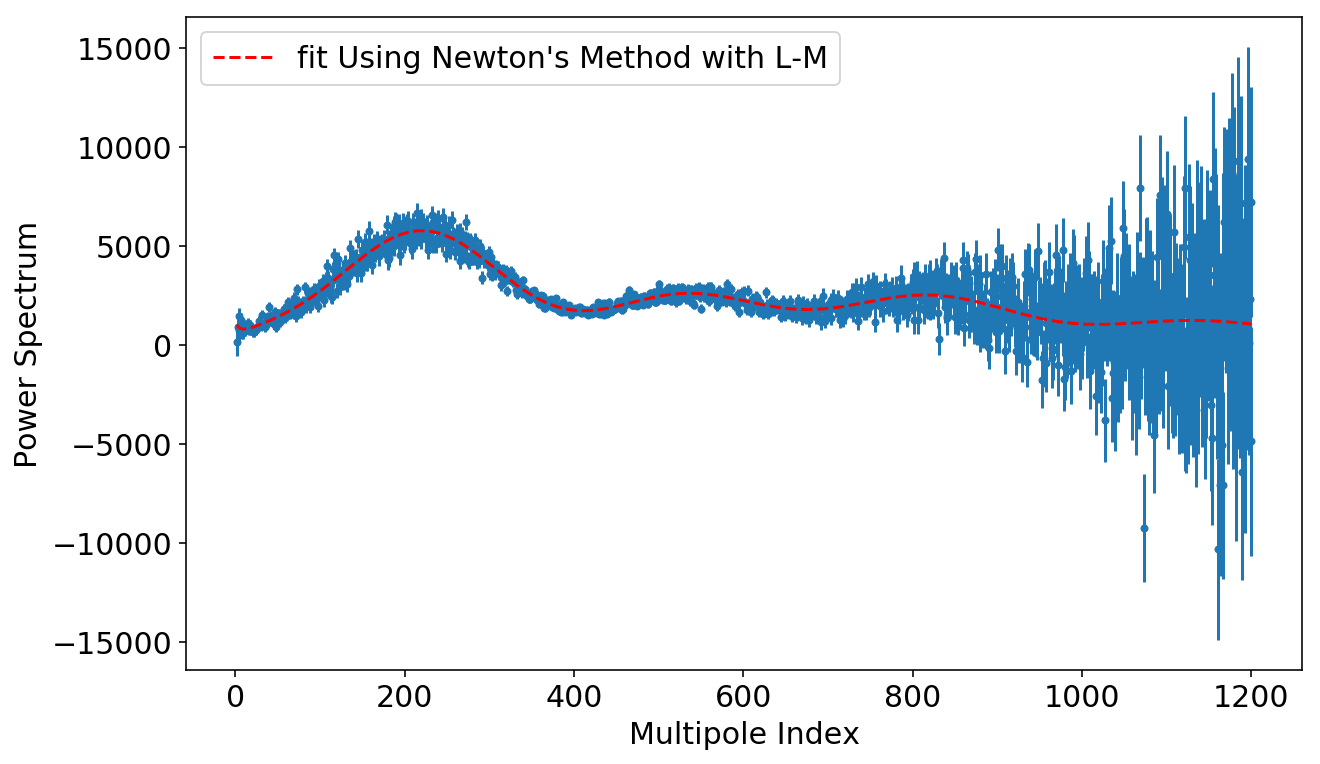

In [336]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(wmap[:,0],fit_mean[2:len(wmap[:,0])+2],'--',color='red',label='fit Using Newton\'s Method with L-M')
ax.errorbar(wmap[:,0],wmap[:,1],yerr=wmap[:,2],fmt='.',zorder=1)
plt.legend(fontsize=15,loc='upper left')
ax.tick_params(labelsize=15)
ax.set_ylabel("Power Spectrum",fontsize=15)
ax.set_xlabel("Multipole Index",fontsize=15)

In [337]:
#Initial guess parameters
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96]) 
new_tau, new_tau_cov,new_tau_error = newton_Method(wmap[:,1],get_spectrum,pars,wmap[:,2],None) 

We are currently in iteration 0; the chi-squared is 1588.2376532931526
1.4285714285714286e-06 

We are currently in iteration 1; the chi-squared is 1235.5504527133958
2.0408163265306123e-08 

We are currently in iteration 2; the chi-squared is 1227.9935873258198
2.915451895043732e-10 

Chi-squared got bigger, I just increased Lambda!
We are currently in iteration 3; the chi-squared is 1227.9935873258198
2.915451895043732e-08 

Chi-squared got bigger, I just increased Lambda!
We are currently in iteration 4; the chi-squared is 1227.9935873258198
2.915451895043732e-06 

Chi-squared got bigger, I just increased Lambda!
We are currently in iteration 5; the chi-squared is 1227.9935873258198
0.0002915451895043732 

Chi-squared got bigger, I just increased Lambda!
We are currently in iteration 6; the chi-squared is 1227.9935873258198
0.029154518950437316 

Chi-squared got bigger, I just increased Lambda!
We are currently in iteration 7; the chi-squared is 1227.9935873258198
2.9154518950437316

In [338]:
print (new_tau)
print (new_tau_error)

[6.87906663e+01 2.23762727e-02 1.14839831e-01 1.88277179e-02
 1.92002929e-09 9.65765121e-01]
[2.87743556e+00 6.69077686e-04 5.85946559e-03 1.44006244e-01
 5.45675134e-10 1.84447820e-02]


# Findings

## Parameters found along with their erros:
The Hubble constant $H_o$ was found to be $69\pm3$.

The Physical Baryon Density was found to be $0.0223\pm0.0007$.

The Cold Dark Matter Density was found to be $0.115\pm0.006$.

The Optical Depth was found to be $0.02\pm0.1$

The Primordial Power Law was found to be $(1.92\pm0.6)\times 10^{-9}$.

The Slope of the Primordial Law was found to be $0.97\pm0.02$

## Plotting: 

The fit was plotted with the found parameters along with the raw power spectrum data

In [342]:
fit_mean = get_spectrum(new_tau,fixed_Tau=None)

Text(0.5, 0, 'Multipole Index')

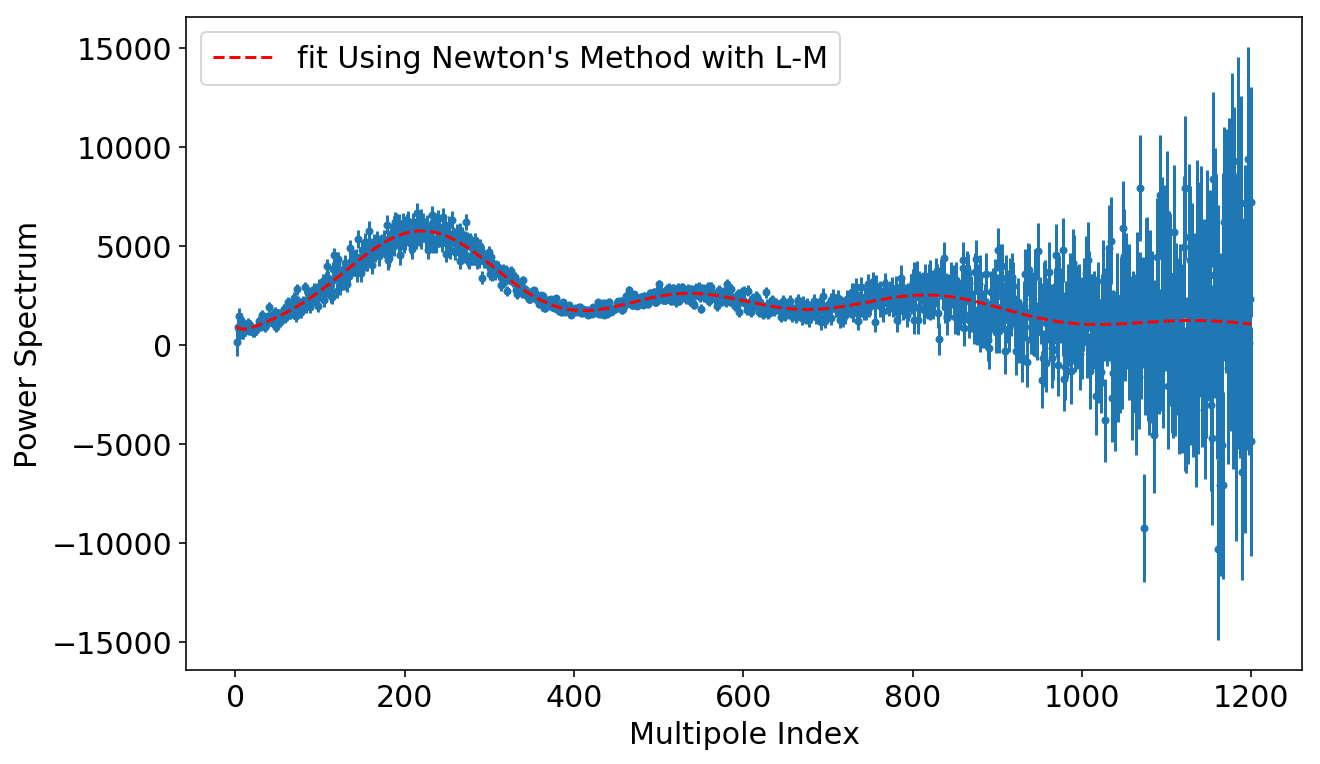

In [343]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(wmap[:,0],fit_mean[2:len(wmap[:,0])+2],'--',color='red',label='fit Using Newton\'s Method with L-M')
ax.errorbar(wmap[:,0],wmap[:,1],yerr=wmap[:,2],fmt='.',zorder=1)
plt.legend(fontsize=15,loc='upper left')
ax.tick_params(labelsize=15)
ax.set_ylabel("Power Spectrum",fontsize=15)
ax.set_xlabel("Multipole Index",fontsize=15)

As one can see from above, when increasing the number of parameters, the error on the parameters increase. Therefore, making tau a float value and fitting everything increases the errors


We can trust our derivatives because in Newton's method, the chi-squared is deacreasing and converging to a solution. The plots above show the resulting fits in red with the first plot having tau being constant and the second one having tau float. We can see that with the definition of the derivatives chosen, the fit seems to be accurate and having a $\chi^2$ around 1227.   